In [1]:
import anndata2ri
import logging
import rpy2.rinterface_lib.callbacks as rcb
import os
import pandas as pd
import numpy as np
import rpy2.robjects as ro
import sys

import scanpy as sc
import matplotlib.pyplot as plt

rcb.logger.setLevel(logging.ERROR)
ro.pandas2ri.activate()
anndata2ri.activate()

%load_ext rpy2.ipython

c:\Users\kyria.000\anaconda3\envs\Py310\lib\site-packages\rpy2\robjects\packages.py:367: UserWarning: The symbol 'quartz' is not in this R namespace/package.
  warnings.warn(


In [2]:
projectdir = "C:/Users/kyria.000/Documents/PhD/Projects/Feng2023/"
datadir = projectdir + "Data/"
resultdir = projectdir + "Result/"
# csv_list = os.listdir(datadir)

h5ad_list = [i for i in os.listdir(resultdir) if i[-5:] == ".h5ad"] 
h5ad_list

['HC_CCR7mCD45ROm_preprocessed.h5ad',
 'HC_CCR7mCD45ROp_preprocessed.h5ad',
 'HC_CCR7pCD45ROm_preprocessed.h5ad',
 'HC_CCR7pCD45ROp_preprocessed.h5ad',
 'PD_CCR7mCD45ROm_preprocessed.h5ad',
 'PD_CCR7mCD45ROp_preprocessed.h5ad',
 'PD_CCR7pCD45ROm_preprocessed.h5ad',
 'PD_CCR7pCD45ROp_preprocessed.h5ad']

In [3]:

adatas=[]
for i in range(len(h5ad_list)):
    print(h5ad_list[i])
    file = resultdir+ h5ad_list[i]
    adata_it = sc.read_h5ad(file)
    adatas.append(adata_it)

adata = adatas[0].concatenate(adatas[1:], join='inner')
adata.X = adata.layers["soupX_counts"].copy()
adata.X.sort_indices()
print(np.shape(adata)) 


HC_CCR7mCD45ROm_preprocessed.h5ad
HC_CCR7mCD45ROp_preprocessed.h5ad
HC_CCR7pCD45ROm_preprocessed.h5ad
HC_CCR7pCD45ROp_preprocessed.h5ad
PD_CCR7mCD45ROm_preprocessed.h5ad
PD_CCR7mCD45ROp_preprocessed.h5ad
PD_CCR7pCD45ROm_preprocessed.h5ad
PD_CCR7pCD45ROp_preprocessed.h5ad


c:\Users\kyria.000\anaconda3\envs\Py310\lib\site-packages\anndata\_core\anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],
c:\Users\kyria.000\anaconda3\envs\Py310\lib\site-packages\anndata\_core\anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],
c:\Users\kyria.000\anaconda3\envs\Py310\lib\site-packages\anndata\_core\anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of a

(40082, 13332)


In [4]:
gene_symbols = pd.read_csv(projectdir+"/features.tsv",sep="\t",header=None)
symbols_in_dataset = adata.var_names 
gene_symbols_infile = gene_symbols[0].tolist()
check =  all(item in gene_symbols_infile for item in symbols_in_dataset)
if check is True:
    print("The ensmble in features contains all elements of the ensemble in merge dataset")   
else :
    print("No, feature.tsv doesn't have all elements of the  merge dataset.")


The ensmble in features contains all elements of the ensemble in merge dataset


In [5]:
gene_symbols.index = gene_symbols[0].tolist()
gene_symbols = gene_symbols.reindex(symbols_in_dataset)
gene_symbols

0           1                2
ENSG00000237491  ENSG00000237491   LINC01409  Gene Expression
ENSG00000228794  ENSG00000228794   LINC01128  Gene Expression
ENSG00000225880  ENSG00000225880   LINC00115  Gene Expression
ENSG00000230368  ENSG00000230368      FAM41C  Gene Expression
ENSG00000188976  ENSG00000188976       NOC2L  Gene Expression
...                          ...         ...              ...
ENSG00000198727  ENSG00000198727      MT-CYB  Gene Expression
ENSG00000278384  ENSG00000278384  AL354822.1  Gene Expression
ENSG00000273748  ENSG00000273748  AL592183.1  Gene Expression
ENSG00000271254  ENSG00000271254  AC240274.1  Gene Expression
ENSG00000278817  ENSG00000278817  AC007325.4  Gene Expression

[13332 rows x 3 columns]

In [6]:
adata.var_names = gene_symbols[1]
adata.var_names_make_unique()

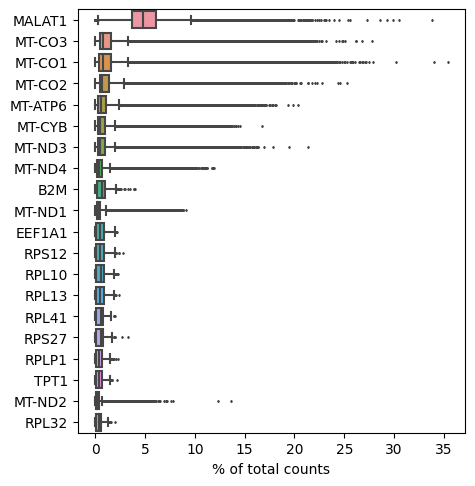

In [7]:
sc.pl.highest_expr_genes(adata, n_top=20)

## REMOVE GENES

In [8]:
import re
# mitochondrial genes
adata.var["mt"] = adata.var_names.str.startswith("MT-", re.I)
# ribosomal genes
adata.var["ribo"] = adata.var_names.str.startswith(("RPS", "RPL"), re.I)
# hemoglobin genes.
adata.var["hb"] = adata.var_names.str.contains(("^HB[^(P)]"), re.I)

sc.pp.calculate_qc_metrics(
    adata, qc_vars=["mt", "ribo", "hb"], inplace=True, percent_top=[20], log1p=True
)

In [9]:
adata.obs["mt_outlier"] =  adata.obs["pct_counts_mt"] > 20
adata.obs.mt_outlier.value_counts()

False    34798
True      5284
Name: mt_outlier, dtype: int64

In [10]:
print(f"Total number of cells: {adata.n_obs}")
adata = adata[(~adata.obs.mt_outlier)].copy()
print(f"Number of cells after filtering of low quality cells: {adata.n_obs}")

Total number of cells: 40082
Number of cells after filtering of low quality cells: 34798


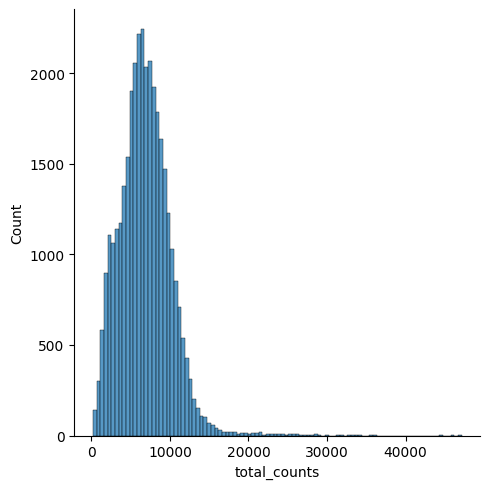

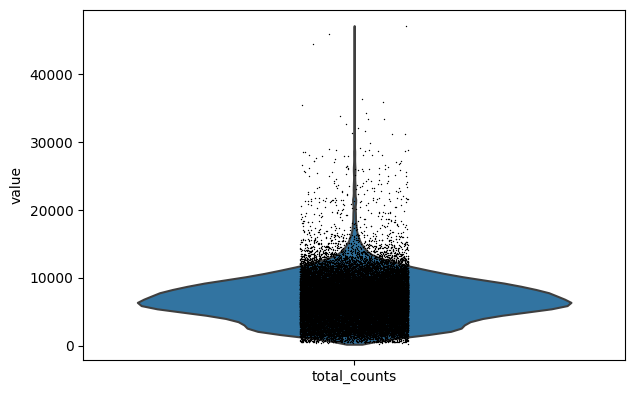

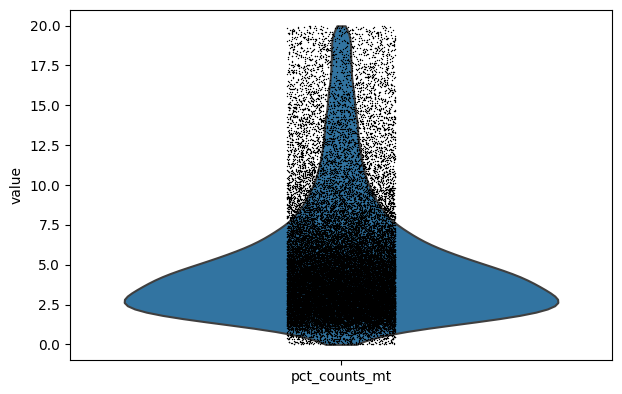

In [11]:
import seaborn as sns
p1 = sns.displot(adata.obs["total_counts"], bins=100, kde=False)
sc.pl.violin(adata, 'total_counts')
p2 = sc.pl.violin(adata, "pct_counts_mt")

In [12]:
genes_remove = []
genes = adata[:,adata.var['mt']==True].var_names
info = 'Mito genes: '+str(len(genes))
print(info)
genes_remove.extend(genes)

genes = adata[:,adata.var['ribo']==True].var_names
info = 'Ribo genes: '+str(len(genes))
print(info)
genes_remove.extend(genes)

genes = adata[:,adata.var['hb']==True].var_names
info = 'Hb genes: '+str(len(genes))
print(info)
genes_remove.extend(genes)


genes_remove = list(set(genes_remove))
info = 'Remove '+str(len(genes_remove))+' genes.'
print(info)

genes_keep = list(set(adata.var_names) - set(genes_remove))
print('Keep '+str(len(genes_keep))+' genes.')

adata = adata[:, genes_keep]

info_meta = 'After genes filter:'
info = str(len(adata.obs))+' cells and '+str(len(adata.var))+' genes'

Mito genes: 13
Ribo genes: 94
Hb genes: 1
Remove 108 genes.
Keep 13224 genes.


In [13]:
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)
adata.layers["logcounts"] = adata.X.copy()
sc.pp.highly_variable_genes(adata)
sc.tl.pca(adata)
sc.pp.neighbors(adata)
sc.tl.umap(adata)
sc.tl.tsne(adata)

c:\Users\kyria.000\anaconda3\envs\Py310\lib\site-packages\scanpy\preprocessing\_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
c:\Users\kyria.000\anaconda3\envs\Py310\lib\site-packages\scanpy\preprocessing\_normalization.py:170: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  view_to_actual(adata)
c:\Users\kyria.000\anaconda3\envs\Py310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [14]:
sc.tl.leiden(adata)
sc.tl.louvain(adata)


c:\Users\kyria.000\anaconda3\envs\Py310\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
c:\Users\kyria.000\anaconda3\envs\Py310\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


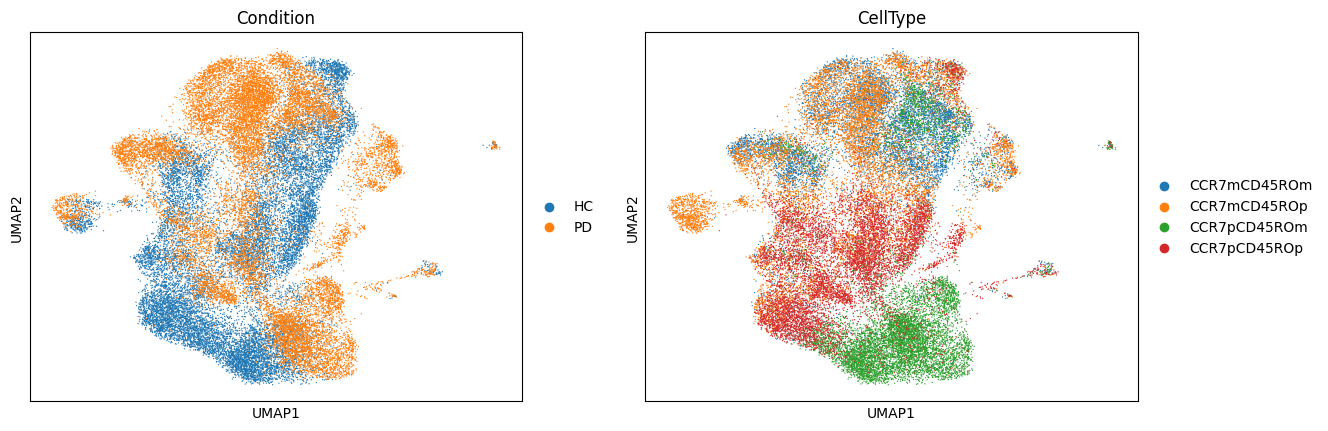

c:\Users\kyria.000\anaconda3\envs\Py310\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


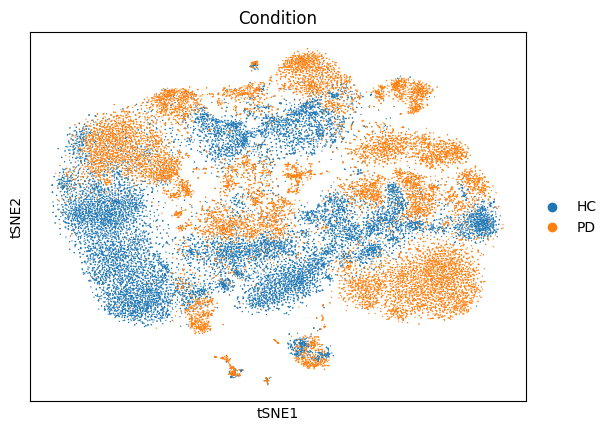

c:\Users\kyria.000\anaconda3\envs\Py310\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
c:\Users\kyria.000\anaconda3\envs\Py310\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


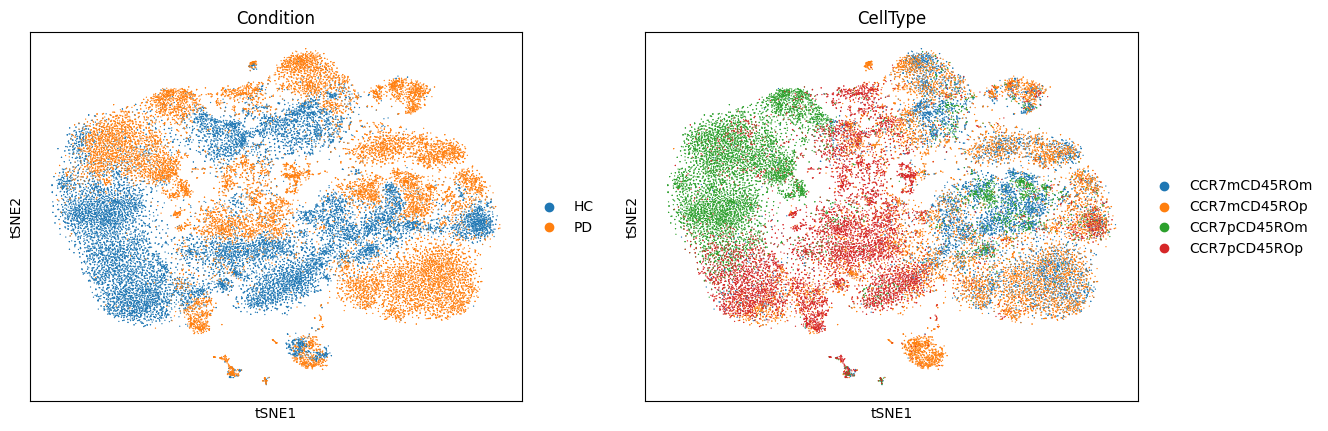

In [15]:
sc.pl.umap(adata, color = ['Condition','CellType'])
sc.pl.tsne(adata, color ='Condition')
sc.pl.tsne(adata, color =['Condition','CellType'])

c:\Users\kyria.000\anaconda3\envs\Py310\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
c:\Users\kyria.000\anaconda3\envs\Py310\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
c:\Users\kyria.000\anaconda3\envs\Py310\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


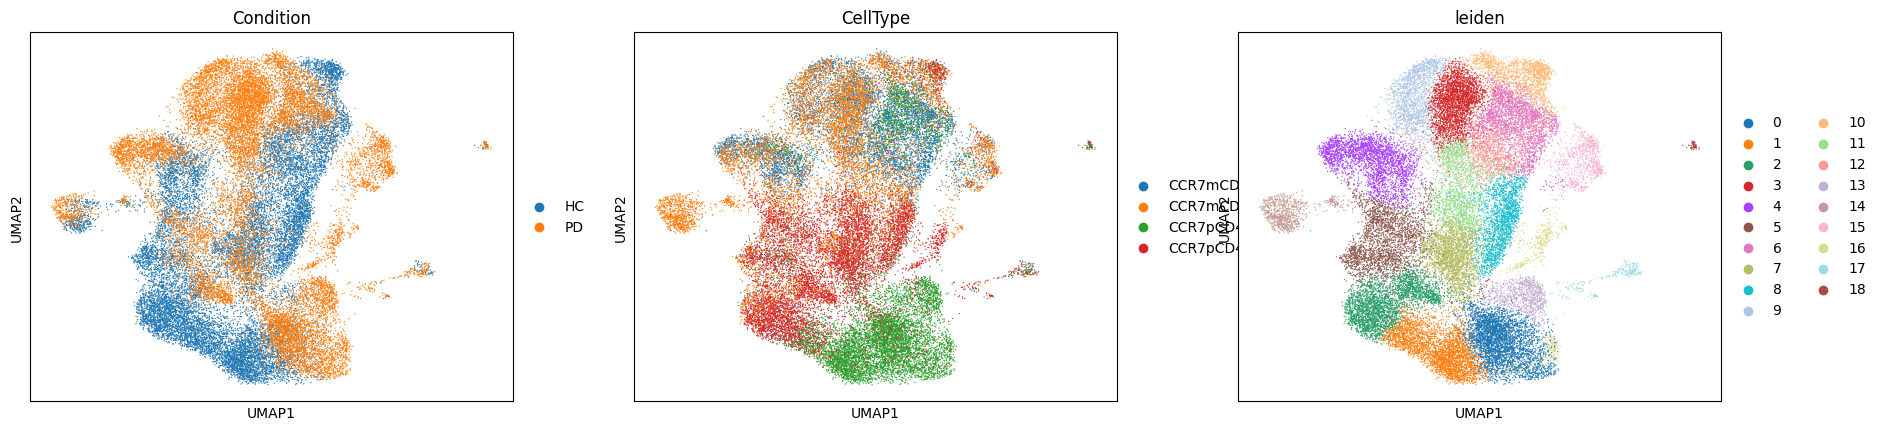

In [16]:
sc.pl.umap(adata, color = ['Condition','CellType','leiden'])


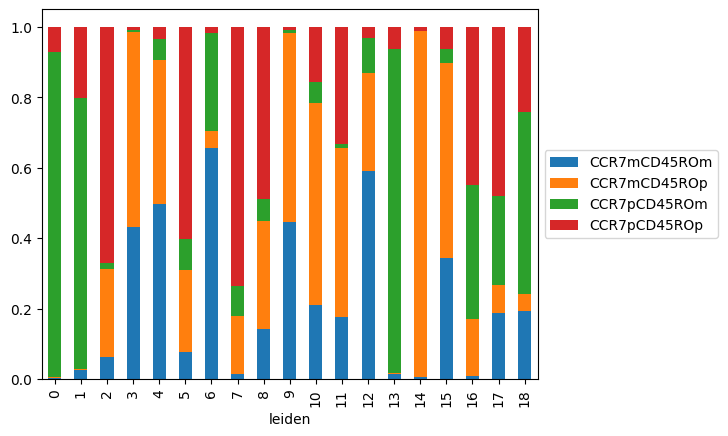

In [17]:
tmp = pd.crosstab(adata.obs['leiden'],adata.obs['CellType'], normalize='index')
tmp.plot.bar(stacked=True).legend(loc='center left', bbox_to_anchor=(1, 0.5))

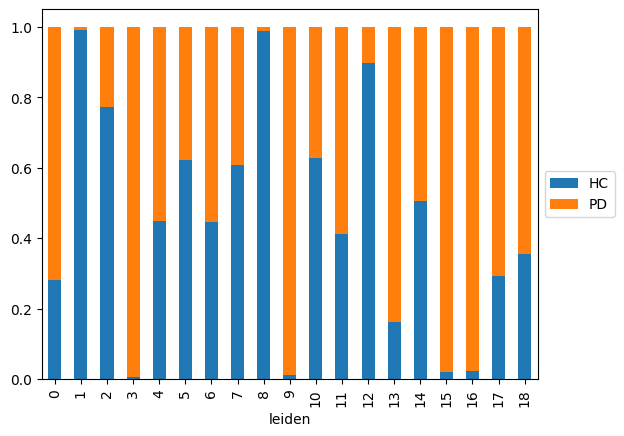

In [18]:
tmp = pd.crosstab(adata.obs['leiden'],adata.obs['Condition'], normalize='index')
tmp.plot.bar(stacked=True).legend(loc='center left', bbox_to_anchor=(1, 0.5))

2023-05-02 09:52:33,686 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2023-05-02 09:52:44,344 - harmonypy - INFO - sklearn.KMeans initialization complete.
2023-05-02 09:52:44,488 - harmonypy - INFO - Iteration 1 of 10
2023-05-02 09:52:54,444 - harmonypy - INFO - Iteration 2 of 10
2023-05-02 09:53:04,354 - harmonypy - INFO - Iteration 3 of 10
2023-05-02 09:53:22,693 - harmonypy - INFO - Iteration 4 of 10
2023-05-02 09:53:48,155 - harmonypy - INFO - Converged after 4 iterations
c:\Users\kyria.000\anaconda3\envs\Py310\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


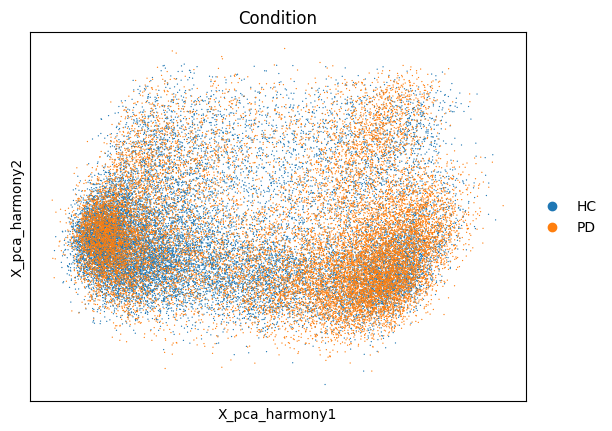

In [19]:
import scanpy.external as sce

sce.pp.harmony_integrate(adata, 'Condition')
sc.pl.embedding(adata, basis='X_pca_harmony', color = ['Condition'])
sc.pp.neighbors(adata, use_rep='X_pca_harmony')
sc.tl.leiden(adata)
sc.tl.louvain(adata)
sc.tl.umap(adata)
adata.obsm["Harmonised_umap"] = adata.obsm["X_umap"].copy()

In [20]:
sc.pp.neighbors(adata, use_rep='X_pca_harmony')
sc.tl.tsne(adata,use_rep='X_pca_harmony')


In [21]:
sc.tl.umap(adata)

c:\Users\kyria.000\anaconda3\envs\Py310\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
c:\Users\kyria.000\anaconda3\envs\Py310\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
c:\Users\kyria.000\anaconda3\envs\Py310\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


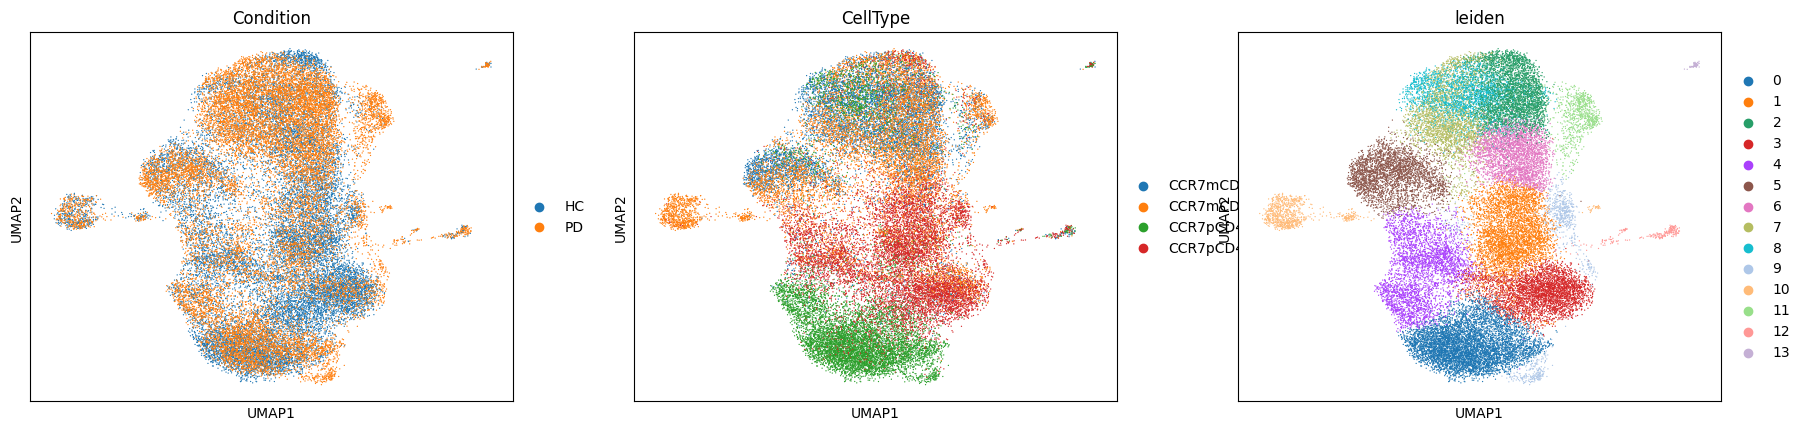

In [22]:
sc.pl.umap(adata, color = ['Condition','CellType','leiden'])


c:\Users\kyria.000\anaconda3\envs\Py310\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


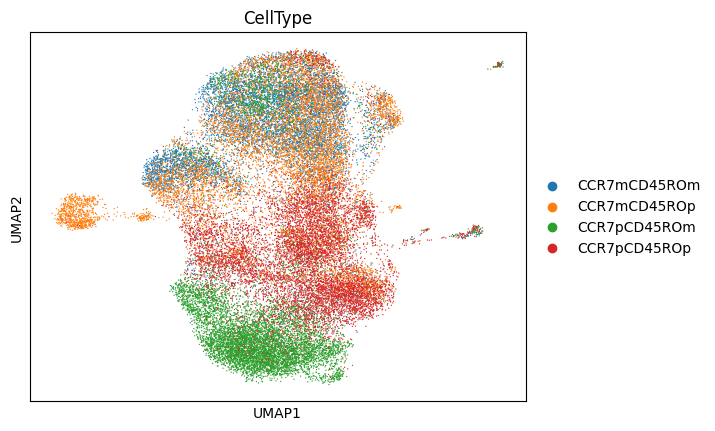

In [23]:
sc.pl.umap(adata, color = ['CellType'])


c:\Users\kyria.000\anaconda3\envs\Py310\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
c:\Users\kyria.000\anaconda3\envs\Py310\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
c:\Users\kyria.000\anaconda3\envs\Py310\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


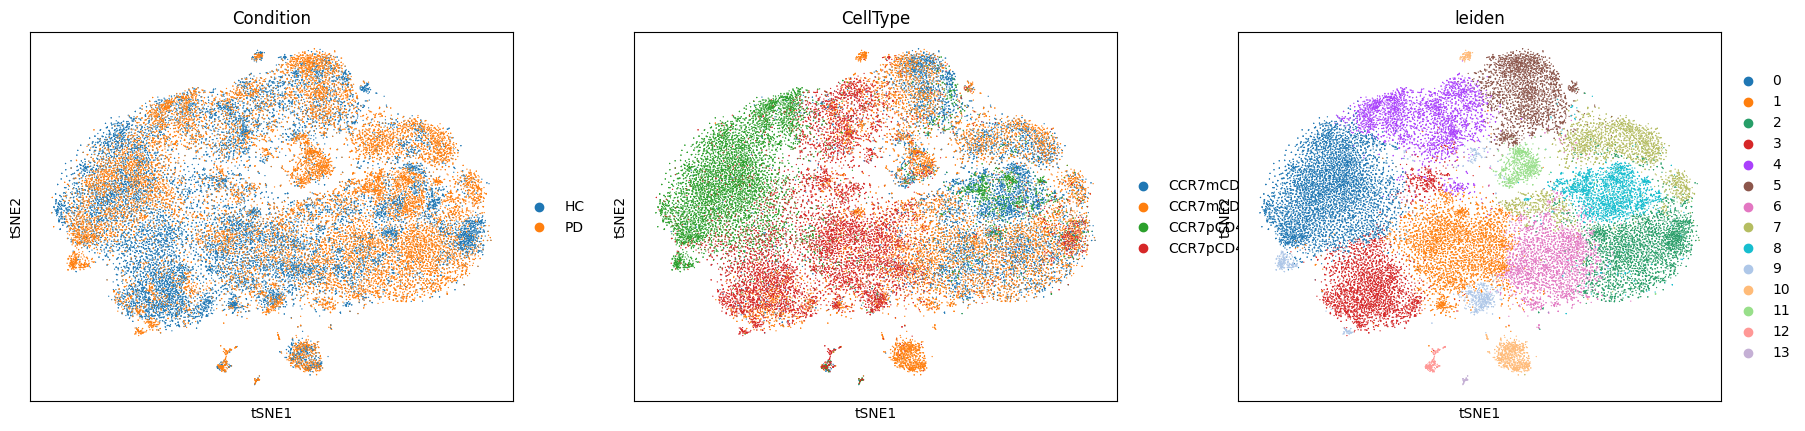

In [24]:
sc.pl.tsne(adata, color = ['Condition','CellType','leiden'])


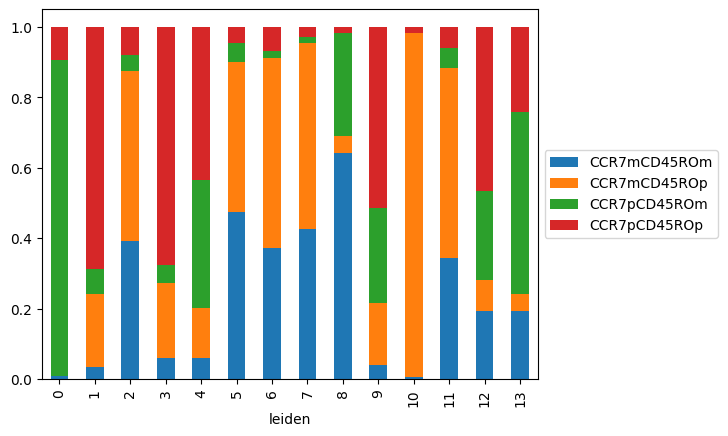

In [25]:
tmp = pd.crosstab(adata.obs['leiden'],adata.obs['CellType'], normalize='index')
tmp.plot.bar(stacked=True).legend(loc='center left', bbox_to_anchor=(1, 0.5))

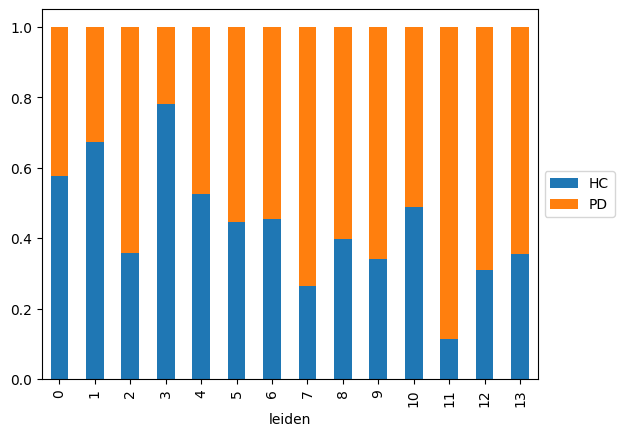

In [26]:
tmp = pd.crosstab(adata.obs['leiden'],adata.obs['Condition'], normalize='index')
tmp.plot.bar(stacked=True).legend(loc='center left', bbox_to_anchor=(1, 0.5))

c:\Users\kyria.000\anaconda3\envs\Py310\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


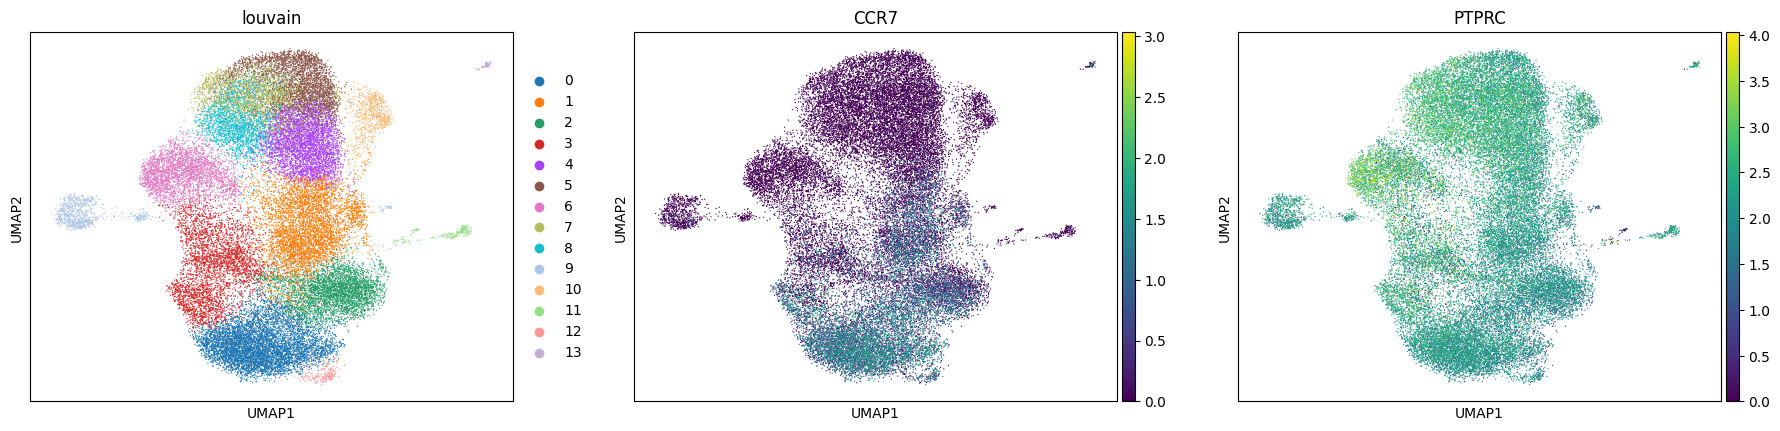

In [27]:
sc.pl.umap(adata, color = ['louvain','CCR7','PTPRC'])


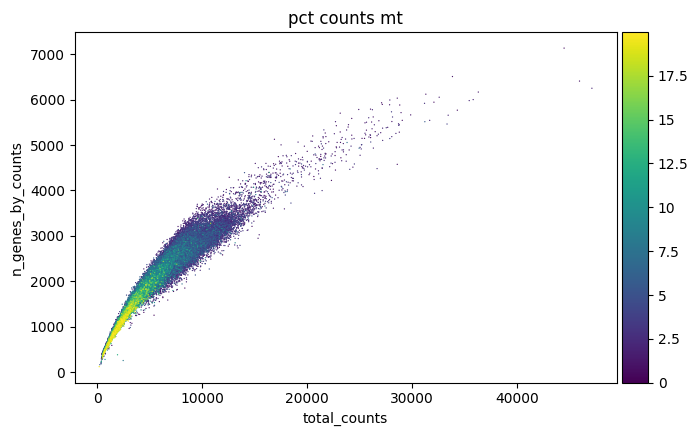

In [28]:
p1 = sc.pl.scatter(adata, "total_counts", "n_genes_by_counts", color="pct_counts_mt")

In [29]:
ls = adata.var_names
 
matches = [match for match in ls if "PTPRC" in match]
 
print(matches)

['PTPRC']


c:\Users\kyria.000\anaconda3\envs\Py310\lib\site-packages\scanpy\plotting\_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


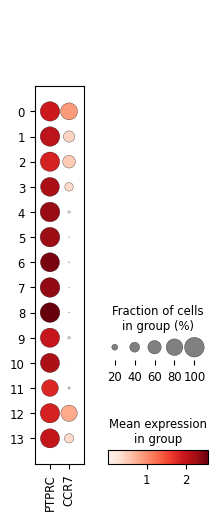

c:\Users\kyria.000\anaconda3\envs\Py310\lib\site-packages\scanpy\plotting\_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


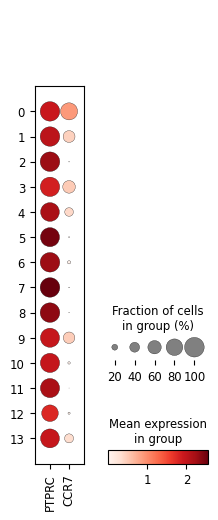

In [30]:
sc.pl.dotplot(adata, ['PTPRC','CCR7'], groupby='louvain')
sc.pl.dotplot(adata, ['PTPRC','CCR7'], groupby='leiden')


c:\Users\kyria.000\anaconda3\envs\Py310\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


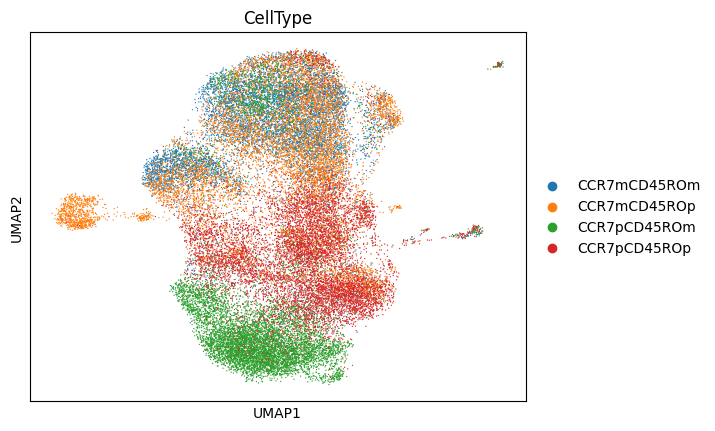

c:\Users\kyria.000\anaconda3\envs\Py310\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


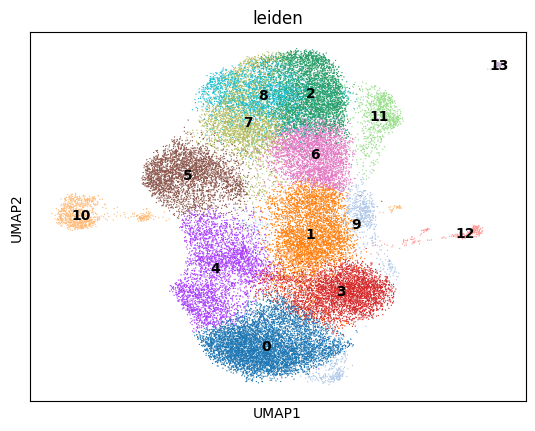

c:\Users\kyria.000\anaconda3\envs\Py310\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


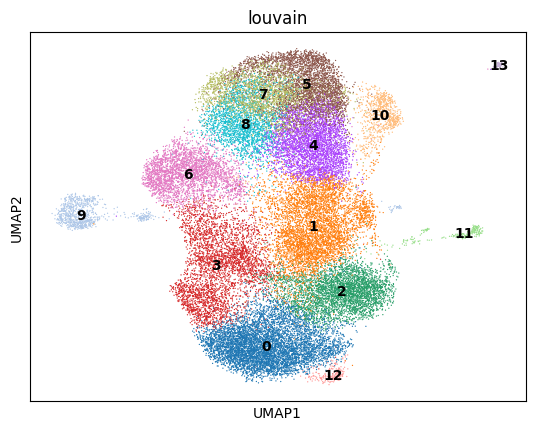

In [31]:
sc.pl.umap(adata, color = ['CellType'])
sc.pl.umap(adata, color = ['leiden'],legend_loc ="on data")
sc.pl.umap(adata, color = ['louvain'],legend_loc ="on data")


## Mitochondrial clusters

c:\Users\kyria.000\anaconda3\envs\Py310\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


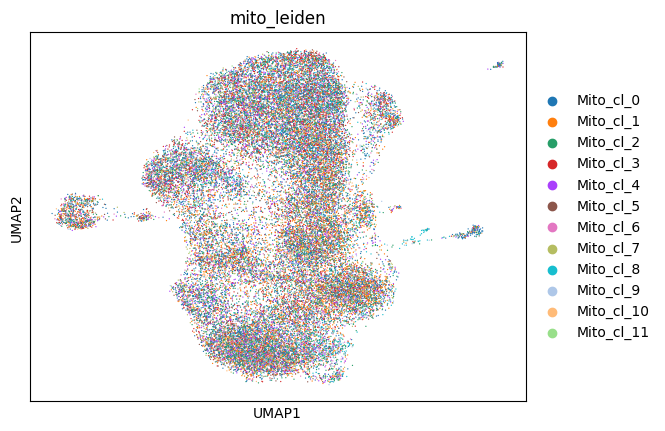

In [46]:
mt_leiden_cl = pd.read_csv(resultdir+"Mito_leiden_cluster.csv")
list_mt_cl = mt_leiden_cl[mt_leiden_cl.columns[1]].values.tolist()
adata.obs['mito_leiden'] = [ "Mito_cl_"+str(x) for x in list_mt_cl ]  
sc.pl.umap(adata, color = ['mito_leiden'])#,legend_loc ="on data")

In [47]:
adata.write(resultdir+'AnnData_Integrated.h5ad')


In [32]:
adata

AnnData object with n_obs × n_vars = 34798 × 13224
    obs: 'n_genes', 'scDblFinder_class', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'Condition', 'CellType', 'batch', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'mt_outlier', 'leiden', 'louvain'
    var: 'n_cells-0', 'n_cells_by_counts-0', 'mean_counts-0', 'log1p_mean_counts-0', 'pct_dropout_by_counts-0', 'total_counts-0', 'log1p_total_counts-0', 'n_cells-1', 'n_cells_by_counts-1', 'mean_counts-1', 'log1p_mean_counts-1', 'pct_dropout_by_counts-1', 'total_counts-1', 'log1p_total_counts-1', 'n_cells-2', 'n_cells_by_counts-2', 'mean_counts-2', 'log1p_mean_counts-2', 'pct_dropout_by_counts-2', 'total_counts-2', 'log1p_total_counts-2', 'n_cells-3', 'n_cells_by_counts-3', 'mean_counts-3', 'log1p_mean_counts-3', 'pct_dropout_by

In [84]:
sc.tl.rank_genes_groups(
    adata, groupby="louvain", method="wilcoxon", key_added="dea_louvain"
)


c:\Users\kyria.000\anaconda3\envs\Py310\lib\site-packages\scanpy\plotting\_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


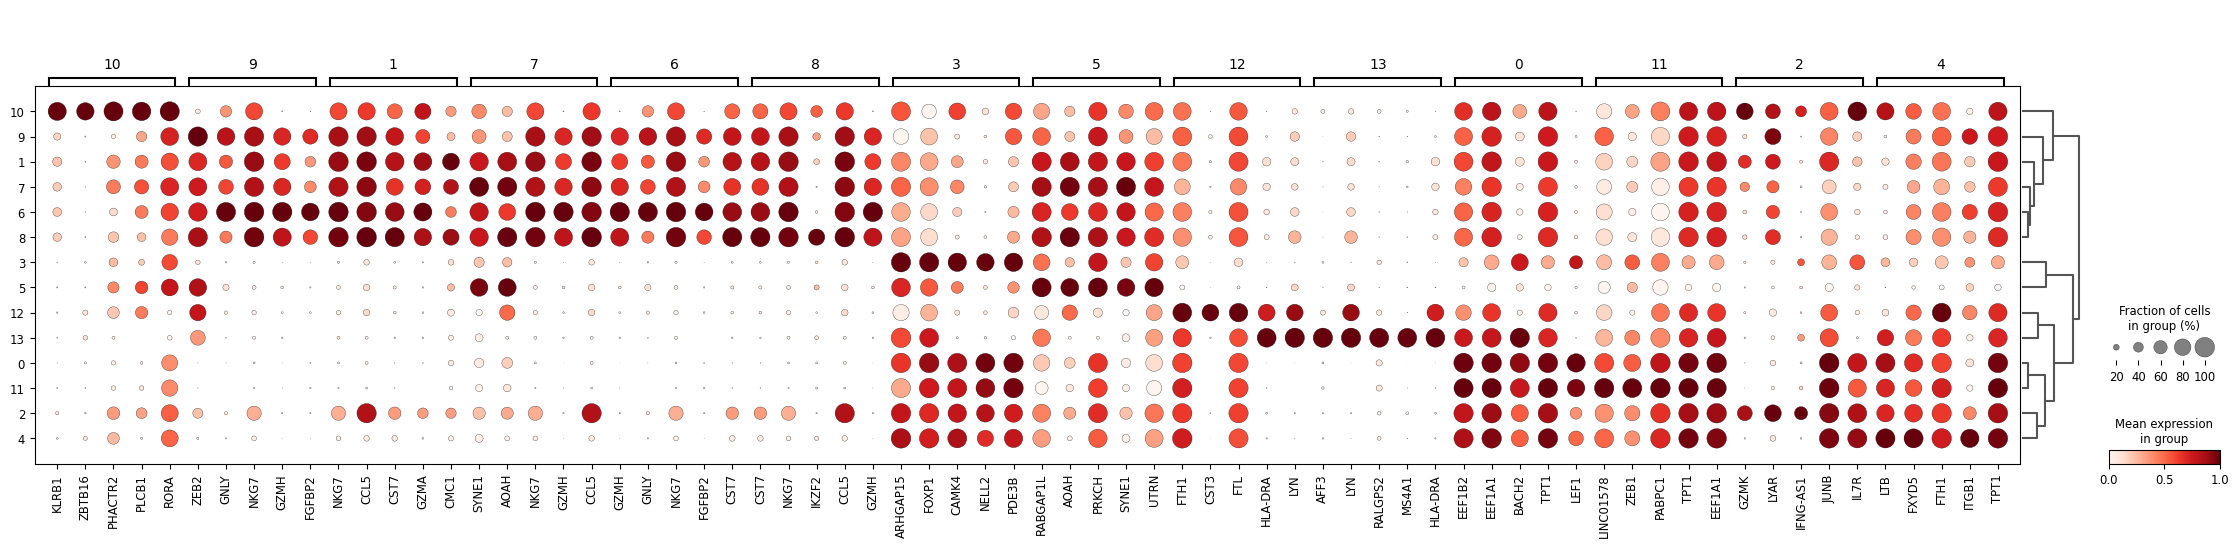

In [85]:
sc.pl.rank_genes_groups_dotplot(
    adata,
    groupby="louvain",
    standard_scale="var",
    n_genes=5,
    key="dea_louvain",
)

In [86]:
sc.tl.filter_rank_genes_groups(
    adata,
    min_in_group_fraction=0.2,
    max_out_group_fraction=0.2,
    key="dea_louvain",
    key_added="dea_louvain_filtered",
)

c:\Users\kyria.000\anaconda3\envs\Py310\lib\site-packages\scanpy\plotting\_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


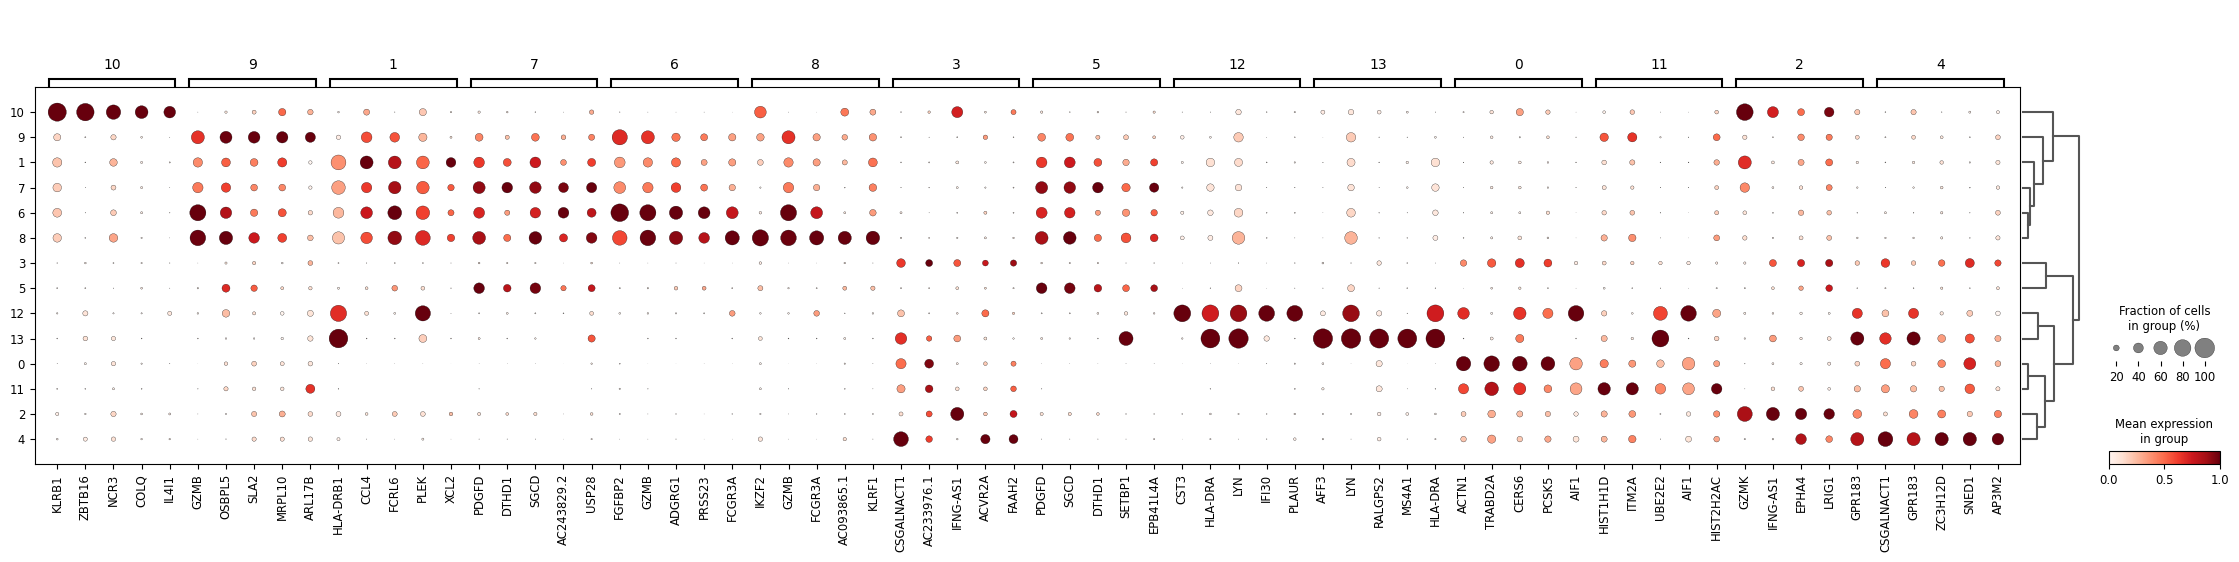

In [97]:
sc.pl.rank_genes_groups_dotplot(
    adata,
    groupby="louvain",
    standard_scale="var",
    n_genes=5,
    key="dea_louvain_filtered",
)



In [91]:
sc.tl.rank_genes_groups(adata, groupby='louvain', method='wilcoxon')

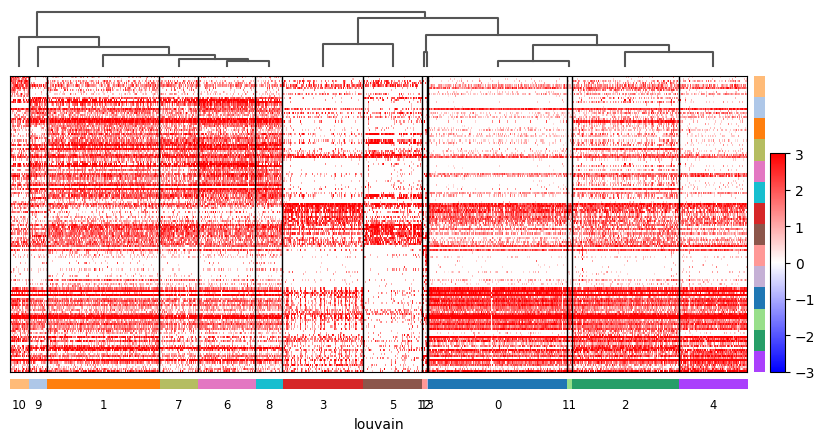

In [92]:
sc.pl.rank_genes_groups_heatmap(adata, n_genes=10, use_raw=False, swap_axes=True, show_gene_labels=False,
                                vmin=-3, vmax=3, cmap='bwr')

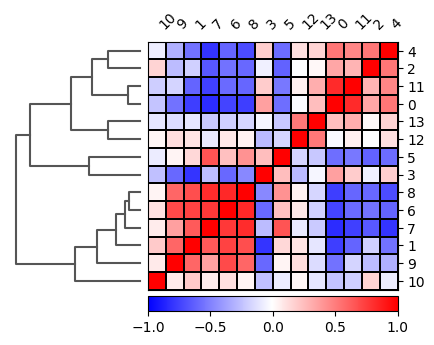

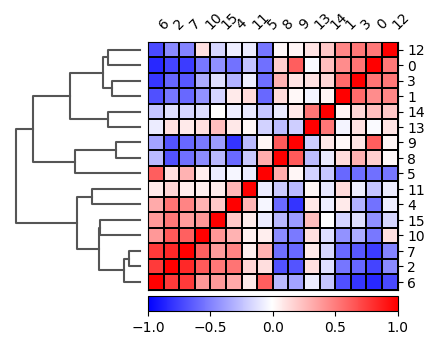

In [99]:
ax = sc.pl.correlation_matrix(adata, 'louvain', figsize=(5,3.5))
ax = sc.pl.correlation_matrix(adata, 'leiden', figsize=(5,3.5))


In [100]:
# Plotting functions - 'GProfiler-official version'
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
from matplotlib import colors
from matplotlib import rcParams


def scale_data_5_75(data):
    mind = np.min(data)
    maxd = np.max(data)
    
    if maxd == mind:
        maxd=maxd+1
        mind=mind-1
        
    drange = maxd - mind
    return ((((data - mind)/drange*0.70)+0.05)*100)
    
def plot_enrich(data, n_terms=20, save=False):
    # Test data input
    if not isinstance(data, pd.DataFrame):
        raise ValueError('Please input a Pandas Dataframe output by gprofiler.')
        
    if not np.all([term in data.columns for term in ['p_value', 'name', 'intersection_size']]):
        raise TypeError('The data frame {} does not contain enrichment results from gprofiler.'.format(data))
    
    data_to_plot = data.iloc[:n_terms,:].copy()
    data_to_plot['go.id'] = data_to_plot.index

    min_pval = data_to_plot['p_value'].min()
    max_pval = data_to_plot['p_value'].max()
    
    # Scale intersection_size to be between 5 and 75 for plotting
    #Note: this is done as calibration was done for values between 5 and 75
    data_to_plot['scaled.overlap'] = scale_data_5_75(data_to_plot['intersection_size'])
    
    norm = colors.LogNorm(min_pval, max_pval)
    sm = plt.cm.ScalarMappable(cmap="cool", norm=norm)
    sm.set_array([])

    rcParams.update({'font.size': 14, 'font.weight': 'bold'})

    sb.set(style="whitegrid")

    path = plt.scatter(x='recall', y="name", c='p_value', cmap='cool', 
                       norm=colors.LogNorm(min_pval, max_pval), 
                       data=data_to_plot, linewidth=1, edgecolor="grey", 
                       s=[(i+10)**1.5 for i in data_to_plot['scaled.overlap']])
    ax = plt.gca()
    ax.invert_yaxis()

    ax.set_ylabel('')
    ax.set_xlabel('Gene ratio', fontsize=14, fontweight='bold')
    ax.xaxis.grid(False)
    ax.yaxis.grid(True)

    # Shrink current axis by 20%
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

    # Get tick marks for this plot
    #Note: 6 ticks maximum
    min_tick = np.floor(np.log10(min_pval)).astype(int)
    max_tick = np.ceil(np.log10(max_pval)).astype(int)
    tick_step = np.ceil((max_tick - min_tick)/6).astype(int)
    
    # Ensure no 0 values
    if tick_step == 0:
        tick_step = 1
        min_tick = max_tick-1
    
    ticks_vals = [10**i for i in range(max_tick, min_tick-1, -tick_step)]
    ticks_labs = ['$10^{'+str(i)+'}$' for i in range(max_tick, min_tick-1, -tick_step)]

    #Colorbar
    fig = plt.gcf()
    cbaxes = fig.add_axes([0.8, 0.15, 0.03, 0.4])
    cbar = ax.figure.colorbar(sm, ticks=ticks_vals, shrink=0.5, anchor=(0,0.1), cax=cbaxes)
    cbar.ax.set_yticklabels(ticks_labs)
    cbar.set_label("Adjusted p-value", fontsize=14, fontweight='bold')

    #Size legend
    min_olap = data_to_plot['intersection_size'].min()
    max_olap = data_to_plot['intersection_size'].max()
    olap_range = max_olap - min_olap
    
    #Note: approximate scaled 5, 25, 50, 75 values are calculated
    #      and then rounded to nearest number divisible by 5
    size_leg_vals = [np.round(i/5)*5 for i in 
                          [min_olap, min_olap+(20/70)*olap_range, min_olap+(45/70)*olap_range, max_olap]]
    size_leg_scaled_vals = scale_data_5_75(size_leg_vals)

    
    l1 = plt.scatter([],[], s=(size_leg_scaled_vals[0]+10)**1.5, edgecolors='none', color='black')
    l2 = plt.scatter([],[], s=(size_leg_scaled_vals[1]+10)**1.5, edgecolors='none', color='black')
    l3 = plt.scatter([],[], s=(size_leg_scaled_vals[2]+10)**1.5, edgecolors='none', color='black')
    l4 = plt.scatter([],[], s=(size_leg_scaled_vals[3]+10)**1.5, edgecolors='none', color='black')

    labels = [str(int(i)) for i in size_leg_vals]

    leg = plt.legend([l1, l2, l3, l4], labels, ncol=1, frameon=False, fontsize=12,
                     handlelength=1, loc = 'center left', borderpad = 1, labelspacing = 1.4,
                     handletextpad=2, title='Gene overlap', scatterpoints = 1,  bbox_to_anchor=(-2, 1.5), 
                     facecolor='black')

    if save:
        plt.savefig(save, dpi=300, format='pdf')

    plt.show()

In [101]:
from gprofiler import GProfiler
#Interpretation of differentially expressed genes in paneth cells - g:profiler
gp = GProfiler(return_dataframe=True, user_agent='g:GOSt')

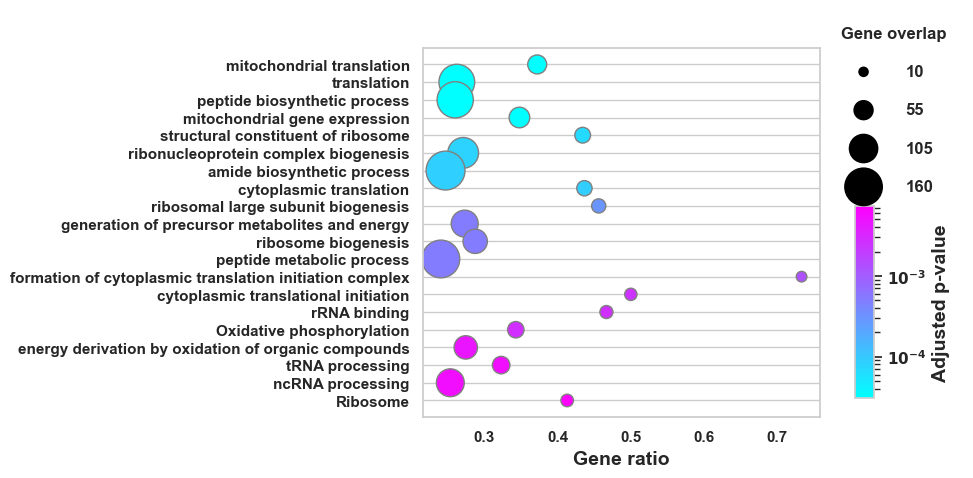

In [104]:
Cl0_genes = sc.get.rank_genes_groups_df(adata, group="0",pval_cutoff=0.01,log2fc_min=0.5)
Cl0_enrichment = gp.profile(organism='hsapiens', sources=['GO:MF','GO:BP','KEGG','WikiPathways'], user_threshold=0.05,
                               significance_threshold_method='fdr', 
                               background=adata.var_names.tolist(), 
                               query=Cl0_genes['names'].tolist())
Cl0_enrichment_results = Cl0_enrichment.set_index('native').sort_values('p_value').iloc[:,[2,5,7,10,1]]
plot_enrich(Cl0_enrichment_results)

In [116]:
import decoupler as dc
msigdb = dc.get_resource('MSigDB')
msigdb['collection'].unique()


array(['oncogenic_signatures', 'mirna_targets',
       'chemical_and_genetic_perturbations', 'immunologic_signatures',
       'tf_targets', 'hallmark', 'cancer_modules', 'positional',
       'reactome_pathways', 'kegg_pathways', 'biocarta_pathways',
       'pid_pathways', 'cancer_gene_neighborhoods'], dtype=object)

In [ ]:
# Filter by hallmark
msigdb = msigdb[msigdb['collection']=='hallmark']
msigdb


In [115]:
# Remove duplicated entries
msigdb = msigdb[~msigdb.duplicated(['geneset', 'genesymbol'])]
msigdb

genesymbol collection                           geneset
11            MSC   hallmark  HALLMARK_TNFA_SIGNALING_VIA_NFKB
149        ICOSLG   hallmark  HALLMARK_TNFA_SIGNALING_VIA_NFKB
223        ICOSLG   hallmark    HALLMARK_INFLAMMATORY_RESPONSE
270        ICOSLG   hallmark      HALLMARK_ALLOGRAFT_REJECTION
398         FOSL2   hallmark                  HALLMARK_HYPOXIA
...           ...        ...                               ...
878342      FOXO1   hallmark      HALLMARK_PANCREAS_BETA_CELLS
878418        GCG   hallmark      HALLMARK_PANCREAS_BETA_CELLS
878512       PDX1   hallmark      HALLMARK_PANCREAS_BETA_CELLS
878605        INS   hallmark      HALLMARK_PANCREAS_BETA_CELLS
878785       SRP9   hallmark      HALLMARK_PANCREAS_BETA_CELLS

[7318 rows x 3 columns]

In [110]:
dc.run_ora(mat=adata, net=msigdb, source='geneset', target='genesymbol', verbose=True,use_raw=False)


Running ora on mat with 34798 samples and 13224 targets for 50 sources.


100%|██████████| 34798/34798 [01:19<00:00, 439.52it/s]
c:\Users\kyria.000\anaconda3\envs\Py310\lib\site-packages\pandas\core\internals\blocks.py:351: RuntimeWarning: divide by zero encountered in log10
  result = func(self.values, **kwargs)


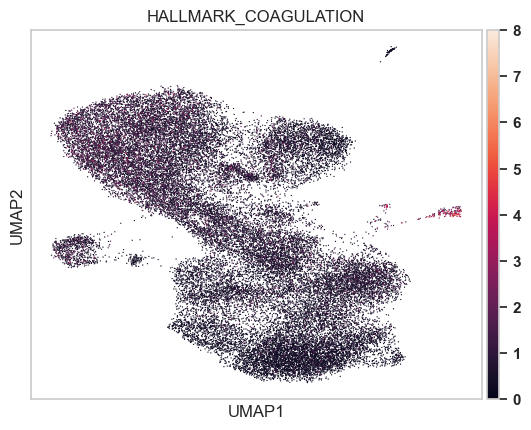

In [112]:
acts = dc.get_acts(adata, obsm_key='ora_estimate')
sc.pl.umap(acts, color='HALLMARK_COAGULATION')

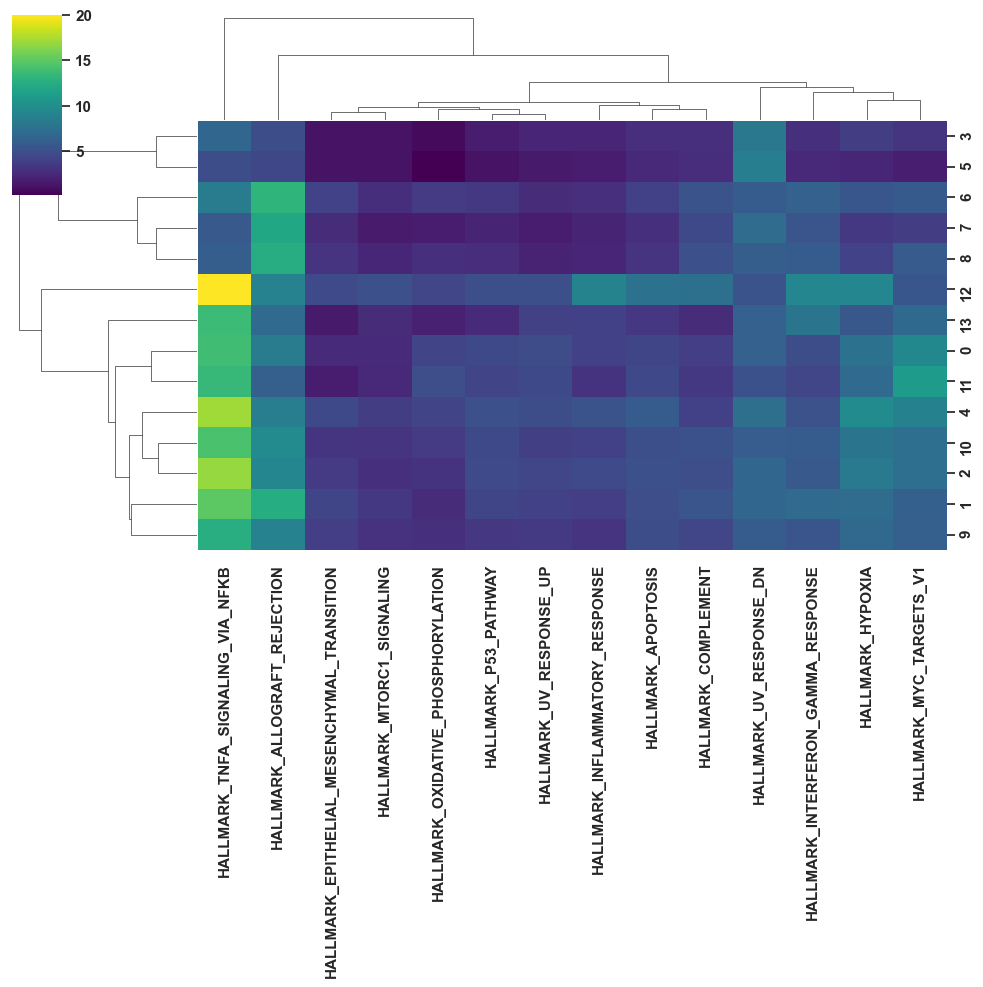

In [113]:
mean_enr = dc.summarize_acts(acts, groupby='louvain', min_std=1)
sns.clustermap(mean_enr, xticklabels=mean_enr.columns, vmax=20, cmap='viridis')
plt.show()

## MAP ON REFERENCE

In [30]:
adata_query = adata.copy()
adata_ref = sc.datasets.pbmc3k_processed()  

In [31]:
var_names = adata_ref.var_names.intersection(adata_query.var_names)
adata_ref = adata_ref[:, var_names]
adata_query = adata_query[:, var_names]

In [32]:
sc.pp.pca(adata_ref)
sc.pp.neighbors(adata_ref)
sc.tl.umap(adata_ref)

c:\Users\kyria.000\anaconda3\envs\Py310\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


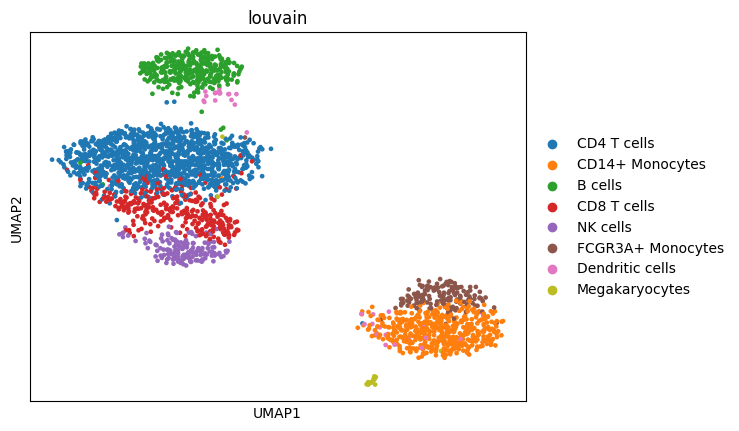

In [34]:
sc.pl.umap(adata_ref, color='louvain')

In [33]:
sc.tl.ingest(adata_query, adata_ref, obs='louvain')


In [35]:
adata_query.uns['louvain_colors'] = adata_ref.uns['louvain_colors']  # fix colors


c:\Users\kyria.000\anaconda3\envs\Py310\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
c:\Users\kyria.000\anaconda3\envs\Py310\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


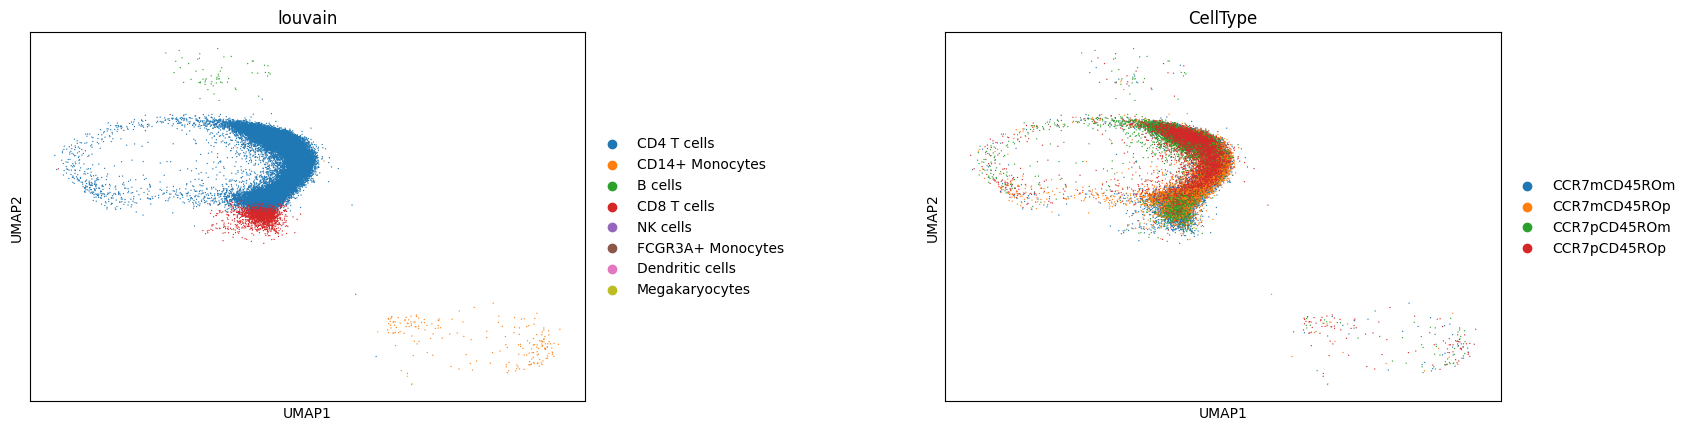

In [38]:
sc.pl.umap(adata_query, color=['louvain', 'CellType'], wspace=0.5)
